# Model Options

- Objective:   Your score is the percentage of passengers you correctly predict, aka accuracy
- Problem type: binary classification
- Following https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 
    - \> 50 samples 
    - predicting a category
    - labeled data 
    - <100K samples
    --> Linear SVC 
    - Linear SVC didn't work too hot. 
    
    
Next one is KNN

In [1]:
# Import the basics 

import pandas as pd
import numpy as np
import sklearn
import os
import sys
sys.path.insert(0, os.path.abspath('../modules'))
import preprocess as pp
import plots

In [2]:
# Read & clean up data

df_raw = pd.read_csv("../data/train.csv")
df = pp.aggregated_preprocess1(df_raw)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(35)

x = df.drop("Survived", axis=1)
y = df.Survived

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

PassengerId, not in col list
Survived, not in col list
Pclass, not in col list
Name, not in col list
converting Sex to category type
Age, not in col list
SibSp, not in col list
Parch, not in col list
converting Ticket to category type
Fare, not in col list
Cabin, not in col list
converting Embarked to category type
converting Deck to category type
Deck_is_missing, not in col list
Age_is_missing, not in col list
Fare_is_missing, not in col list


In [3]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Deck_is_missing,Age_is_missing,Fare_is_missing
0,0,3,2,22.0,1,0,524,7.2500,3,17,1,0,0
1,1,1,1,38.0,1,0,597,71.2833,1,6,0,0,0
2,1,3,1,26.0,0,0,670,7.9250,3,17,1,0,0
3,1,1,1,35.0,1,0,50,53.1000,3,6,0,0,0
4,0,3,2,35.0,0,0,473,8.0500,3,17,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Sex              891 non-null    int8   
 3   Age              891 non-null    float64
 4   SibSp            891 non-null    int64  
 5   Parch            891 non-null    int64  
 6   Ticket           891 non-null    int16  
 7   Fare             891 non-null    float64
 8   Embarked         891 non-null    int8   
 9   Deck             891 non-null    int8   
 10  Deck_is_missing  891 non-null    int64  
 11  Age_is_missing   891 non-null    int64  
 12  Fare_is_missing  891 non-null    int64  
dtypes: float64(2), int16(1), int64(7), int8(3)
memory usage: 67.1 KB


In [5]:
df.isna().sum()

Survived           0
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           0
Deck               0
Deck_is_missing    0
Age_is_missing     0
Fare_is_missing    0
dtype: int64

In [6]:
df.loc[(df.Age == -1)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Deck_is_missing,Age_is_missing,Fare_is_missing


# Model Tuning 

Based on the documentation, https://scikit-learn.org/stable/modules/neighbors.html :
- KNN can be supervised or unsupervised. I believe since we have the target var, we'll want the supervised classification.
- KDTree or BallTree are options for finding neighbors
    - KD Tree is more efficient than brute force distance calculation, but can suffer with a lot of dimensions
    - Ball Tree - "partitions data into nesting hyperspheres"!!
    - both have a leaf size parameter: controls the number of samples at which a query switches to brute-force
- there's a k-neighbors option and a radius option: 
    - pick k closest points vs. pick all points within a radius
    - if "data is not uniformly sampled, radius-based neighbors classification... can be a better choice", but is not ideal for high-dimensional parameter spaces
- The basic nearest neighbors classification uses uniform weights: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the weights keyword. The default value, weights = 'uniform', assigns uniform weights to each neighbor. weights = 'distance' assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied to compute the weights.


In [7]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer

grid= {"n_neighbors": np.arange(6, 22, 2), 
        "leaf_size": np.arange(2, 14, 2),
        "weights": ["uniform", "distance"], 
        'p': [1,2],
        'metric': ['minkowski', 'chebyshev', 'correlation', 'dice']}

gs_model = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid,
                        cv= 5)

gs_model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([ 2,  4,  6,  8, 10, 12]),
                         'metric': ['minkowski', 'chebyshev', 'correlation',
                                    'dice'],
                         'n_neighbors': array([ 6,  8, 10, 12, 14, 16, 18, 20]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [8]:
gs_model.best_params_

{'leaf_size': 2,
 'metric': 'minkowski',
 'n_neighbors': 12,
 'p': 1,
 'weights': 'distance'}

In [9]:
best_score = gs_model.score(x_test, y_test)
best_model = gs_model

gs_model.best_score_, best_score

(0.7261302078203486, 0.6927374301675978)

This seems to be recommending more neighbors, but I don't see an improvement in accuracy with more neighbors. Let's try a few more numbers...

In [10]:
grid2 = {"n_neighbors": np.arange(10, 60, 5), 
        "leaf_size": [2,5,10],
        "weights": ["uniform", "distance"], 
        'p': [1,2],
        'metric': ['minkowski', 'chebyshev', 'correlation', 'dice']}

gs_model2 = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid2,
                        cv= 5)

gs_model2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [2, 5, 10],
                         'metric': ['minkowski', 'chebyshev', 'correlation',
                                    'dice'],
                         'n_neighbors': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [11]:
gs_model2.best_params_

{'leaf_size': 2,
 'metric': 'minkowski',
 'n_neighbors': 30,
 'p': 1,
 'weights': 'distance'}

In [12]:
gs_model2_score = gs_model2.score(x_test, y_test)
gs_model2.best_score_, gs_model2_score

if gs_model2_score > best_score:
    best_score = gs_model2_score
    best_model = gs_model2


gs_model2.best_score_, gs_model2_score, best_score

(0.7247316064217473, 0.664804469273743, 0.6927374301675978)

interesting. gs_model2 fits training data better, but unseen data worse. 

In [13]:
y_preds = gs_model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       106
           1       0.70      0.42      0.53        73

    accuracy                           0.69       179
   macro avg       0.70      0.65      0.65       179
weighted avg       0.70      0.69      0.67       179



In [14]:
y_preds = gs_model2.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.67      0.87      0.75       106
           1       0.66      0.37      0.47        73

    accuracy                           0.66       179
   macro avg       0.66      0.62      0.61       179
weighted avg       0.66      0.66      0.64       179



### Best model with unscaled features: gs_model2 
 `'leaf_size': 2,
 'metric': 'minkowski',
 'n_neighbors': 12,
 'p': 1,
 'weights': 'distance'`

In [15]:
data_desc = df.describe().T
data_spread = data_desc[["min", "max"]]
data_spread

,min,max
Survived,0.0000,1.0000
Pclass,1.0000,3.0000
Sex,1.0000,2.0000
Age,0.4200,80.0000
SibSp,0.0000,8.0000
Parch,0.0000,6.0000
Ticket,1.0000,681.0000
Fare,4.0125,512.3292
Embarked,0.0000,3.0000
Deck,1.0000,17.0000


In [16]:
# Scale it!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scale_df = df.copy()
scale_arr = scaler.fit_transform(scale_df)
scale_df = pd.DataFrame(scale_arr)
scale_df.columns = df.columns
scale_df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Deck_is_missing,Age_is_missing,Fare_is_missing
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.769118,0.006369,1.000000,1.0000,1.0,0.0,0.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.876471,0.132340,0.333333,0.3125,0.0,0.0,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.983824,0.007697,1.000000,1.0000,1.0,0.0,0.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.072059,0.096569,1.000000,0.3125,0.0,0.0,0.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.694118,0.007943,1.000000,1.0000,1.0,0.0,0.0


In [17]:
desc = scale_df.describe().T
spread = desc[["min", "max"]]
spread

,min,max
Survived,0.0,1.0
Pclass,0.0,1.0
Sex,0.0,1.0
Age,0.0,1.0
SibSp,0.0,1.0
Parch,0.0,1.0
Ticket,0.0,1.0
Fare,0.0,1.0
Embarked,0.0,1.0
Deck,0.0,1.0


In [18]:
scale_df_x = scale_df.drop("Survived", axis=1)
scale_df_y = scale_df.Survived

scaled_x_train, scaled_x_test, scaled_y_train, scaled_y_test = train_test_split(scale_df_x, scale_df_y, test_size=.2 )

grid3= {"n_neighbors": np.arange(2, 40, 5), 
        "leaf_size": np.arange(2, 14, 2),
        "weights": ["uniform", "distance"], 
        'p': [1,2],
        'metric': ['minkowski', 'chebyshev', 'correlation', 'dice']}

gs_model3 = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid,
                        cv= 5)

gs_model3.fit(scaled_x_train, scaled_y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([ 2,  4,  6,  8, 10, 12]),
                         'metric': ['minkowski', 'chebyshev', 'correlation',
                                    'dice'],
                         'n_neighbors': array([ 6,  8, 10, 12, 14, 16, 18, 20]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [19]:
gs_model3.best_params_

{'leaf_size': 2,
 'metric': 'minkowski',
 'n_neighbors': 20,
 'p': 1,
 'weights': 'uniform'}

In [20]:
gs_model3_score = gs_model3.score(scaled_x_test, scaled_y_test)

if gs_model3_score > best_score:
    best_score = gs_model3_score
    best_model = gs_model3


gs_model3.best_score_, gs_model3_score, best_score

(0.8103910174332709, 0.8156424581005587, 0.8156424581005587)

In [21]:
scaled_y_preds = gs_model3.predict(scaled_x_test)
print(classification_report(scaled_y_test, scaled_y_preds))

              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86       110
         1.0       0.89      0.59      0.71        69

    accuracy                           0.82       179
   macro avg       0.84      0.77      0.79       179
weighted avg       0.83      0.82      0.81       179



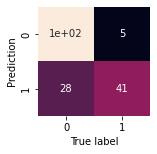

In [22]:
plots.draw_confusion_matrix(scaled_y_test, scaled_y_preds) 

In [23]:
best_model.best_params_, best_score

({'leaf_size': 2,
  'metric': 'minkowski',
  'n_neighbors': 20,
  'p': 1,
  'weights': 'uniform'},
 0.8156424581005587)

### Best model overall: gs_model3, trained on scaled features
 `'leaf_size': 4,
  'metric': 'minkowski',
  'n_neighbors': 18,
  'p': 1,
  'weights': 'distance'`

Let's run this on the real data and convert to Kaggle format

In [24]:
raw_test_df = pd.read_csv("../data/test.csv")
test_PassengerIDs = raw_test_df.PassengerId
test_df = pp.aggregated_preprocess1(raw_test_df)

PassengerId, not in col list
Pclass, not in col list
Name, not in col list
converting Sex to category type
Age, not in col list
SibSp, not in col list
Parch, not in col list
converting Ticket to category type
Fare, not in col list
Cabin, not in col list
converting Embarked to category type
converting Deck to category type
Deck_is_missing, not in col list
Age_is_missing, not in col list
Fare_is_missing, not in col list


In [25]:
# Scale it!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

test_scale_df = test_df.copy()
test_scale_arr = scaler.fit_transform(test_scale_df)
test_scale_df = pd.DataFrame(test_scale_arr)
test_scale_df.columns = test_df.columns
test_scale_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Deck_is_missing,Age_is_missing,Fare_is_missing
0,1.0,1.0,0.452723,0.000,0.000000,0.419890,0.009149,0.5,1.0,1.0,0.0,0.0
1,1.0,0.0,0.617566,0.125,0.000000,0.610497,0.007521,1.0,1.0,1.0,0.0,0.0
2,0.5,1.0,0.815377,0.000,0.000000,0.201657,0.012799,0.5,1.0,1.0,0.0,0.0
3,1.0,1.0,0.353818,0.000,0.000000,0.406077,0.010786,1.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.287881,0.125,0.111111,0.381215,0.017905,1.0,1.0,1.0,0.0,0.0


In [26]:
desc = test_scale_df.describe().T
spread = desc[["min", "max"]]
spread

,min,max
Pclass,0.0,1.0
Sex,0.0,1.0
Age,0.0,1.0
SibSp,0.0,1.0
Parch,0.0,1.0
Ticket,0.0,1.0
Fare,0.0,1.0
Embarked,0.0,1.0
Deck,0.0,1.0
Deck_is_missing,0.0,1.0


In [27]:

test_preds = gs_model3.predict(test_scale_df)

In [34]:
kaggle_data = pd.DataFrame()
kaggle_data["PassengerId"] = test_PassengerIDs
kaggle_data["Survived"] = test_preds.astype(int)

In [36]:
best_score_percent = round(best_score, 3)*100
kaggle_data.to_csv("../result-csv/KNN-"+str(best_score_percent)+"p_accuracy.csv", index=False)

In [37]:
len(kaggle_data)

418